In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile

pd.set_option('max_colwidth', 280)

%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set()
sns.set_context("talk")
import re
import tweepy

# Downloading Recent Tweets


In [2]:
import json
key_file = 'keys.json'
with open(key_file) as f:
    keys = json.load(f)

In [3]:
from tweepy import TweepError
import logging

try:
    auth = tweepy.OAuthHandler(keys["consumer_key"], keys["consumer_secret"])
    auth.set_access_token(keys["access_token"], keys["access_token_secret"])
    api = tweepy.API(auth)
    print("Your username is:", api.auth.get_username())
except TweepError as e:
    logging.warning("There was a Tweepy error. Double check your API keys and try again.")
    logging.warning(e)

Your username is: 15jfan


In [4]:
from pathlib import Path
import json

ds_tweets_save_path = "BerkeleyData_recent_tweets.json"
# Guarding against attempts to download the data multiple
# times:
if not Path(ds_tweets_save_path).is_file():
    # Getting as many recent tweets by @BerkeleyData as Twitter will let us have.
    # We use tweet_mode='extended' so that Twitter gives us full 280 character tweets.
    
    # The tweepy Cursor API actually returns "sophisticated" Status objects but 
    # will use the basic Python dictionaries stored in the _json field. 
    example_tweets = [t._json for t in tweepy.Cursor(api.user_timeline, id="BerkeleyData", 
                                             tweet_mode='extended').items()]
    
    # Saving the tweets to a json file on disk for future analysis
    with open(ds_tweets_save_path, "w") as f:        
        json.dump(example_tweets, f)

# Re-loading the json file:
with open(ds_tweets_save_path, "r") as f:
    example_tweets = json.load(f)

In [5]:
# Looking at one tweet object, which has type Status: 
from pprint import pprint # ...to get a more easily-readable view.
pprint(example_tweets[0])

{'contributors': None,
 'coordinates': None,
 'created_at': 'Wed Feb 14 18:47:23 +0000 2018',
 'display_text_range': [0, 144],
 'entities': {'hashtags': [],
              'symbols': [],
              'urls': [],
              'user_mentions': [{'id': 263020833,
                                 'id_str': '263020833',
                                 'indices': [3, 19],
                                 'name': 'Berkeley School of Information',
                                 'screen_name': 'BerkeleyISchool'}]},
 'favorite_count': 0,
 'favorited': False,
 'full_text': 'RT @BerkeleyISchool: We LOVE the I School community! 💓💖💗 Our '
              'students, alumni, faculty &amp; staff make the I School a '
              'incredible place to lear…',
 'geo': None,
 'id': 963847153784369152,
 'id_str': '963847153784369152',
 'in_reply_to_screen_name': None,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'is_

In [6]:
def load_keys(path):
    """Loads Twitter authentication keys from a file on disk.
    
    Returns:
        dict: A dictionary mapping key names (like "consumer_key") to
          key values."""
    ds_tweets_save_path = path
    if not Path(ds_tweets_save_path).is_file():
        example_tweets = [t._json for t in tweepy.Cursor(api.user_timeline, id="BerkeleyData", 
                                             tweet_mode='extended').items()]    
        with open(ds_tweets_save_path, "w") as f:        
            json.dump(example_tweets, f)

# Re-loading the json file:
    with open(ds_tweets_save_path, "r") as f:
        example_tweets = json.load(f)
    return example_tweets

In [7]:
def download_recent_tweets_by_user(user_account_name, keys):
    """Downloads tweets by one Twitter user.

    Returns:
        list: A list of Dictonary objects, each representing one tweet."""

    try:
        auth = tweepy.OAuthHandler(keys["consumer_key"], keys["consumer_secret"])
        auth.set_access_token(keys["access_token"], keys["access_token_secret"])
        api = tweepy.API(auth)
    except TweepError as e:
        logging.warning("There was a Tweepy error. Double check your API keys and try again.")
        logging.warning(e)
    example_tweets = [t._json for t in tweepy.Cursor(api.user_timeline, id=user_account_name, 
                                             tweet_mode='extended').items()]
    return example_tweets
    

In [8]:
def save_tweets(tweets, path):
    """Saves a list of tweets to a file in the local filesystem.
    
    Returns:
        None"""
    out_file = open(path, "w+")
    json.dump(tweets, out_file)
   

In [9]:
def load_tweets(path):
    """Loads tweets that have previously been saved.
    
    Returns:
        list: A list of Dictionary objects, each representing one tweet."""
    with open(path) as f:
        x = json.load(f)
    return x 


In [10]:
def get_tweets_with_cache(user_account_name, keys_path):
    """Get recent tweets from one user, loading from a disk cache if available.
    
    """
    try: 
        return load_tweets("tweets.json")
    except: 
        x = download_recent_tweets_by_user(user_account_name, load_keys(keys_path))
        save_tweets(x, "tweets.json")
        return x        
    

In [11]:
trump_tweets = get_tweets_with_cache("realdonaldtrump", key_file)
print("Number of tweets downloaded:", len(trump_tweets))

Number of tweets downloaded: 3215


In [22]:
#determining what the oldest tweet accessible is 
oldest_date = pd.to_datetime(pd.Series([t["created_at"] for t in trump_tweets])).min()
oldest_date

Timestamp('2016-10-27 12:17:57')

In [23]:
from utils import fetch_and_cache
#combining current data with earlier snapshot of the tweets
data_url = 'http://www.ds100.org/sp18/assets/datasets/old_trump_tweets.json.zip'
file_name = 'old_trump_tweets.json.zip'

dest_path = fetch_and_cache(data_url=data_url, file=file_name)
print(f'Located at {dest_path}')

Using version already downloaded: Sun Feb 18 14:33:11 2018
MD5 hash of file: d9419cad17e76c87fe646b587f6e8ca5
Located at data\old_trump_tweets.json.zip


In [24]:
my_zip = zipfile.ZipFile(dest_path, 'r')
with my_zip.open("old_trump_tweets.json", "r") as f:
    old_trump_tweets = json.load(f)

In [25]:
pprint(old_trump_tweets[0])

{'contributors': None,
 'coordinates': None,
 'created_at': 'Wed Oct 12 14:00:48 +0000 2016',
 'entities': {'hashtags': [{'indices': [23, 38], 'text': 'CrookedHillary'}],
              'media': [{'display_url': 'pic.twitter.com/wjsl8ITVvk',
                         'expanded_url': 'https://twitter.com/realDonaldTrump/status/786204978629185536/video/1',
                         'id': 786204885318561792,
                         'id_str': '786204885318561792',
                         'indices': [39, 62],
                         'media_url': 'http://pbs.twimg.com/ext_tw_video_thumb/786204885318561792/pu/img/XqMoixLm83FzkAbn.jpg',
                         'media_url_https': 'https://pbs.twimg.com/ext_tw_video_thumb/786204885318561792/pu/img/XqMoixLm83FzkAbn.jpg',
                         'sizes': {'large': {'h': 576,
                                             'resize': 'fit',
                                             'w': 1024},
                                   'medium': {'h': 338

In [26]:
old_trump_tweets[0].keys()

dict_keys(['created_at', 'id', 'id_str', 'text', 'truncated', 'entities', 'extended_entities', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive', 'lang'])

In [33]:
#merging old tweets with recent tweets
import copy 
lst1 = copy.copy(trump_tweets)
lst2 = copy.copy(old_trump_tweets)
lst1.extend(lst2)
ids = []
all_tweets = []
for Dict in lst1:
    if Dict["id"] not in ids:
        ids.append(Dict["id"])
        all_tweets.append(Dict)

In [28]:
all_tweets[0].keys()

dict_keys(['created_at', 'id', 'id_str', 'full_text', 'truncated', 'display_text_range', 'entities', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'lang'])

# Determining the source from which tweets are sent

In [35]:
#creating dataframe to work with
index = [x["id"] for x in all_tweets]
time = [pd.to_datetime(x["created_at"]) for x in all_tweets]
source = [x["source"] for x in all_tweets]
text = []
for Dict in all_tweets:
    try: 
        text.append(Dict["full_text"])
    except:
        text.append(Dict["text"])
retweet_count = [x["retweet_count"] for x in all_tweets]
trump = pd.DataFrame({"index": index,
                    "time": time, 
                     "source": source,
                     "text": text,
                     "retweet_count": retweet_count})
trump.set_index("index", inplace = True)
trump = trump.sort_index()


In [36]:
trump['source'].unique()

array([ '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>',
       '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="https://mobile.twitter.com" rel="nofollow">Mobile Web (M5)</a>',
       '<a href="http://instagram.com" rel="nofollow">Instagram</a>',
       '<a href="http://twitter.com/#!/download/ipad" rel="nofollow">Twitter for iPad</a>',
       '<a href="https://studio.twitter.com" rel="nofollow">Media Studio</a>',
       '<a href="https://periscope.tv" rel="nofollow">Periscope</a>',
       '<a href="https://ads.twitter.com" rel="nofollow">Twitter Ads</a>'], dtype=object)

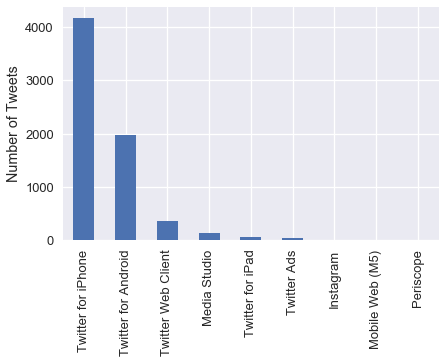

In [37]:
#removing HTML tags from source and plotting source of tweets
trump['source'] = trump["source"].str.replace("<.*?>", "").str.replace("</a>", "")
trump['source'].value_counts().plot(kind="bar")
plt.ylabel("Number of Tweets");

In [38]:
for t in trump_tweets[0:3]:
    print(t['created_at'])

Sun Feb 18 19:13:02 +0000 2018
Sun Feb 18 17:10:32 +0000 2018
Sun Feb 18 13:55:55 +0000 2018


In [39]:
#Converting time stamp to Eastern time
trump['est_time'] = (
    trump['time'].dt.tz_localize("UTC") # Setting initial timezone to UTC
                 .dt.tz_convert("EST") # Convert to Eastern Time
)
trump.head()

,retweet_count,source,text,time,est_time
index,,,,,
690171032150237184,1059,Twitter for Android,"""@bigop1: @realDonaldTrump @SarahPalinUSA https://t.co/3kYQGqeVyD""",2016-01-21 13:56:11,2016-01-21 08:56:11-05:00
690171403388104704,1339,Twitter for Android,"""@AmericanAsPie: @glennbeck @SarahPalinUSA Remember when Glenn gave out gifts to ILLEGAL ALIENS at crossing the border? Me too!""",2016-01-21 13:57:39,2016-01-21 08:57:39-05:00
690173226341691392,2006,Twitter for Android,So sad that @CNN and many others refused to show the massive crowd at the arena yesterday in Oklahoma. Dishonest reporting!,2016-01-21 14:04:54,2016-01-21 09:04:54-05:00
690176882055114758,2266,Twitter for Android,"Sad sack @JebBush has just done another ad on me, with special interest money, saying I won't beat Hillary - I WILL. But he can't beat me.",2016-01-21 14:19:26,2016-01-21 09:19:26-05:00
690180284189310976,2886,Twitter for Android,Low energy candidate @JebBush has wasted $80 million on his failed presidential campaign. Millions spent on me. He should go home and relax!,2016-01-21 14:32:57,2016-01-21 09:32:57-05:00


In [40]:
#convert time to hours
hour = trump["est_time"].astype(str).str.slice(11,13).astype(int)
minute = trump["est_time"].astype(str).str.slice(14,16).astype(int)
second = trump["est_time"].astype(str).str.slice(17,19).astype(int)
trump['hour'] = hour + minute/60 + second/60**2

# Visualization of tweets according to hour of the day

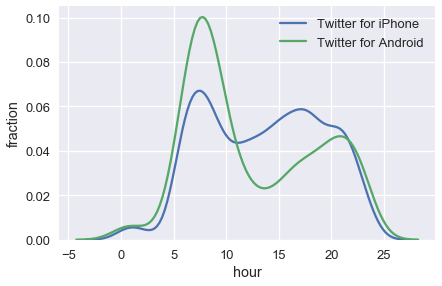

In [41]:
sns.distplot(trump[trump["source"] == "Twitter for iPhone"]["hour"], hist = False, label = "Twitter for iPhone")
sns.distplot(trump[trump["source"] == "Twitter for Android"]["hour"], hist = False, label = "Twitter for Android")
plt.ylabel("fraction");
plt.legend();
axes = plt.gca()
axes.set_ylim(0, .105);

Notes: There isn't much tweeting between the hours of midnight to 4am which makes sense because Trump would likely be sleeping. There is a large spike at around 7 or 8am so Trump tends to tweet before starting his day. There is a much higher spike in the use of the android device in the morning around 7 and 8am. Then after around noon to about 8pm, the iphone is used more than the android. 

In [42]:
#Examining tweet habits by months and year
import datetime
def year_fraction(date):
    start = datetime.date(date.year, 1, 1).toordinal()
    year_length = datetime.date(date.year+1, 1, 1).toordinal() - start
    return date.year + float(date.toordinal() - start) / year_length


trump['year'] = trump['time'].apply(year_fraction)

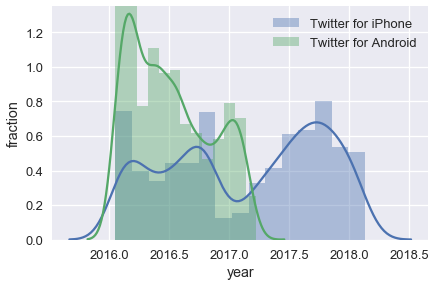

In [43]:
sns.distplot(trump[trump["source"] == "Twitter for iPhone"]["year"], label = "Twitter for iPhone")
sns.distplot(trump[trump["source"] == "Twitter for Android"]["year"], label = "Twitter for Android")
plt.ylabel("fraction");
plt.legend();
axes = plt.gca()
axes.set_ylim(0, 1.35);

Trump claims to have switch over from android to apple at around February of 2017. Up until that point, the android use was significantly higher than iphone use. However at around January there is a sharp decline in the android phone and an increase in the use of the apple phone. Then the use of android abruptly stopped and only the apple phone is used at around February 2017 which is consistent to his claim. 

# Sentiment Analysis of Tweets

In [44]:
#Using Vader lexicon 
sent = pd.read_table("vader_lexicon.txt", header=None, usecols = [0,1])
sent = sent.set_index(0).rename(columns = {1: "polarity"})

#cleaning texts
trump["text"] = trump["text"].str.lower()
punct_re = r'[^\w\s]'
trump['no_punc'] = trump["text"].str.replace(punct_re, " ")
#displaying each unique word per a tweet
tidy_format = (trump["no_punc"]
               .str.strip()
               .str.split("\s+", expand = True)
               .stack()
               .to_frame())
tidy_format.reset_index(inplace = True)
tidy_format = tidy_format.set_index("index")
tidy_format.columns = ["num", "word"]
tidy_format


,num,word
index,,
690171032150237184,0,bigop1
690171032150237184,1,realdonaldtrump
690171032150237184,2,sarahpalinusa
690171032150237184,3,https
690171032150237184,4,t
690171032150237184,5,co
690171032150237184,6,3kyqgqevyd
690171403388104704,0,americanaspie
690171403388104704,1,glennbeck


In [46]:
#merge the table with the vader lexicon to get score for each word and add
#sentiment score to the tweet
merged = tidy_format.merge(
    sent, 
    left_on = "word", 
    right_index = True, 
    how = "left")
merged = merged.fillna(0)
trump['polarity'] = merged.groupby(merged.index).aggregate(sum)["polarity"]



In [47]:
print('Most negative tweets:')
for t in trump.sort_values('polarity').head()['text']:
    print('\n  ', t)

Most negative tweets:

   horrible and cowardly terrorist attack on innocent and defenseless worshipers in egypt. the world cannot tolerate terrorism, we must defeat them militarily and discredit the extremist ideology that forms the basis of their existence!

   democrat jon ossoff would be a disaster in congress. very weak on crime and illegal immigration, bad for jobs and wants higher taxes. say no

   "@fiiibuster: @jeffzeleny pathetic - you have no sufficient evidence that donald trump did not suffer from voter fraud, shame! bad reporter.

   nyc terrorist was happy as he asked to hang isis flag in his hospital room. he killed 8 people, badly injured 12. should get death penalty!

   yet another terrorist attack today in israel -- a father, shot at by a palestinian terrorist, was killed while:
https://t.co/cv1hzkvbit


In [48]:
print('Most positive tweets:')
for t in trump.sort_values('polarity', ascending=False).head()['text']:
    print('\n  ', t)

Most positive tweets:

   thank you to linda bean of l.l.bean for your great support and courage. people will support you even more now. buy l.l.bean. @lbperfectmaine

   it was my great honor to celebrate the opening of two extraordinary museums-the mississippi state history museum &amp; the mississippi civil rights museum. we pay solemn tribute to our heroes of the past &amp; dedicate ourselves to building a future of freedom, equality, justice &amp; peace. https://t.co/5akgvpv8aa

   rt @ivankatrump: 2016 has been one of the most eventful and exciting years of my life. i wish you peace, joy, love and laughter. happy new…

   today, it was my great honor to sign a new executive order to ensure veterans have the resources they need as they transition back to civilian life. we must ensure that our heroes are given the care and support they so richly deserve! https://t.co/0mdp9ddias https://t.co/lp2a8kcbap

   it was my great honor to welcome mayor’s from across america to the wh. my ad

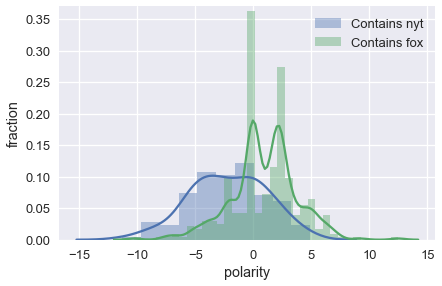

In [50]:
#distribution of tweet sentiments based on whether the tweet contains 
#the words nyt or fox
sns.distplot(trump[(trump["no_punc"].str.contains("nyt"))]["polarity"], label = "Contains nyt"); 
sns.distplot(trump[trump["no_punc"].str.contains("fox")]["polarity"], label = "Contains fox");
plt.ylabel("fraction");
plt.legend();
axes = plt.gca()
axes.set_ylim(0, 0.37);

As expected, if the tweet contains "nyt", then the tweet is more likely to be negative and if the tweet contains "fox", then the tweet is more likely to be positive. 

In [51]:
#Finding the top 20 most retweeted words 
tidy_grouped = tidy_format.groupby("word").count()
tidy_grouped = tidy_grouped[tidy_grouped["num"] >= 25]
x = (trump["no_punc"]
               .str.strip()
               .str.split("\s+", expand = True)
               .stack()
               .to_frame())
y = x.merge(trump["retweet_count"].to_frame(), left_index = True, right_index = True)
y.head()
z = tidy_grouped.merge(y, left_index = True, right_on = 0, how = "inner")
top_tweets = z.groupby(0).aggregate(np.median).sort_values("retweet_count", ascending = False)
top_20 = top_tweets.iloc[0:20, :]
top_20 = top_20["retweet_count"].to_frame()
top_20.index.names = ["word"]
top_20

,retweet_count
word,
nfl,24748.0
daca,24498.0
anthem,24336.5
fbi,23978.0
russia,23490.0
fake,23327.0
schumer,22881.0
collusion,22754.0
unemployment,22536.0


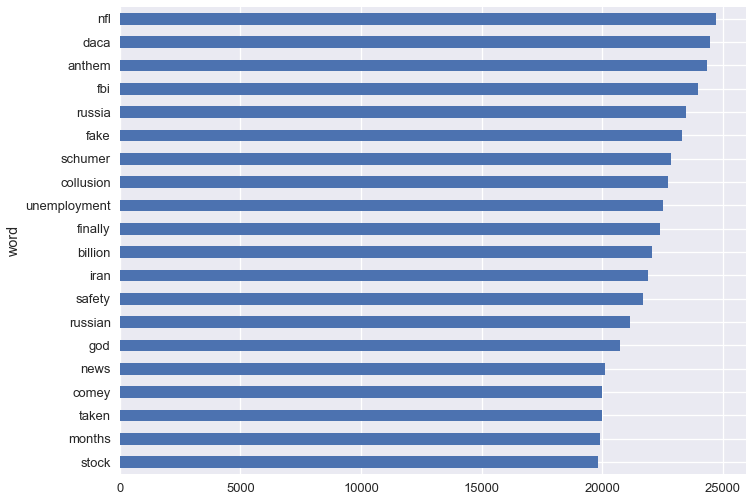

In [52]:
top_20['retweet_count'].sort_values().plot.barh(figsize=(10, 8));

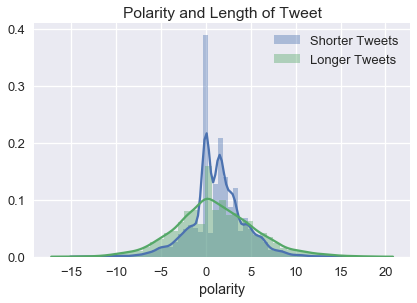

In [53]:
#Looking at how the polarity of the tweet differs from long and short tweets
word_count = tidy_format.groupby(tidy_format.index).count()["word"]
trump["word_count"] = word_count
med = word_count.median()
sns.distplot(trump[trump["word_count"] <= med]["polarity"], label = "Shorter Tweets"); 
sns.distplot(trump[trump["word_count"] > med]["polarity"], label = "Longer Tweets");
plt.legend();
plt.title("Polarity and Length of Tweet");

Looking at the length of the tweets, the long tweets is more symmetric than the short tweets. However, both short and long tweets appears to be slighly right skewed. Somewhat positive tweets tend to be shorter lengthed tweets while negative and extremely positive tweets tend to be longer tweets. 

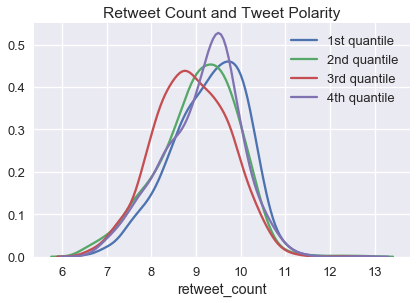

In [54]:
#Looking to see how the polarity of the tweet affects retweet counts
slightly_negative_trump = trump[
    (trump["polarity"] >= trump["polarity"].quantile(q = 0.25)) &
    (trump["polarity"] < trump["polarity"].quantile(q = 0.50))]
slightly_positive_trump = trump[
    (trump["polarity"] >= trump["polarity"].quantile(q = 0.50)) &
    (trump["polarity"] < trump["polarity"].quantile(q = 0.75))]
really_negative_trump = trump[trump["polarity"] < trump["polarity"].quantile(q = 0.25)]["retweet_count"]
really_positive_trump = trump[trump["polarity"] >= trump["polarity"].quantile(q = 0.75)]["retweet_count"]
sns.distplot(np.log(really_negative_trump), hist = False, label = "1st quantile");
sns.distplot(np.log(slightly_negative_trump["retweet_count"]), hist = False, label = "2nd quantile");
sns.distplot(np.log(slightly_positive_trump["retweet_count"]), hist = False, label = "3rd quantile");
sns.distplot(np.log(really_positive_trump), hist = False, label = "4th quantile");
plt.legend();
axes = plt.gca();
axes.set_ylim(0, 0.55);
plt.title("Retweet Count and Tweet Polarity");

In [55]:
snt = slightly_negative_trump
pos_snt = snt[snt["polarity"] > 0]
neg_snt = snt[snt["polarity"] < 0]
zero_snt = snt[snt["polarity"] == 0]
[snt.shape, pos_snt.shape, neg_snt.shape, zero_snt.shape]
[neg_snt["retweet_count"].median(), pos_snt["retweet_count"].median(), zero_snt["retweet_count"].median()]

[12056.5, 12214.0, 7960.5]

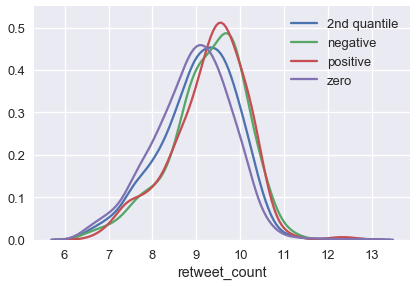

In [56]:
sns.distplot(np.log(slightly_negative_trump["retweet_count"]), hist = False, label = "2nd quantile");
sns.distplot(np.log(neg_snt["retweet_count"]), hist = False, label = "negative");
sns.distplot(np.log(pos_snt["retweet_count"]), hist = False, label = "positive");
sns.distplot(np.log(zero_snt["retweet_count"]), hist = False, label = "zero");
plt.legend();
axes = plt.gca();
axes.set_ylim(0, 0.55);

In [57]:
spt = slightly_positive_trump
spt_sorted = list(spt["time"].sort_values())
[spt_sorted[len(spt_sorted)//4],
 spt_sorted[len(spt_sorted)//2],
 spt_sorted[3 * len(spt_sorted)//4]]

[Timestamp('2016-05-01 23:37:17'),
 Timestamp('2016-09-27 12:55:31'),
 Timestamp('2017-05-03 03:06:16')]

In [58]:
snt_sorted = list(snt["time"].sort_values())
[snt_sorted[len(snt_sorted)//4],
 snt_sorted[len(snt_sorted)//2],
 snt_sorted[3 * len(snt_sorted)//4]]

[Timestamp('2016-05-18 00:57:16'),
 Timestamp('2016-10-20 00:58:56'),
 Timestamp('2017-07-05 11:14:11')]

Looking at the distribution of retweet counts from different quantiles of the tweet polarity, the most retweeted tweets come from the 1st quantile, or the really negative tweets. Then a slighly higher amount of retweets come from the 4th quantile, or the most positive tweets. Then slighly more retweets come from the 2nd quantile, leaving the least number of retweets coming from the 3rd quantile. The slightly negative tweets have both positive and negative polarity, and the majority of the slightly negative tweets have no polarity at all. It is composed of 421 positive tweets, 230 negative tweets, and 978 tweets with 0 polarity. Looking at the distribution of the positive and negative tweets that make up the 2nd quartile distribution, they appear very similar with the positive tweets having a slightly higher median than the negative tweets. Finally looking at the quantiles of the timeframe in which the 2nd and 3rd quantile tweets were tweeted, the 2nd quantile tweets were tweeted at later dates than the 3rd quantile tweets. So the reason why the 2nd quantile tweets have a higher retweet count than the 3rd quantile tweets is probably due to Trumps increase in followers. 